<a href="https://colab.research.google.com/github/Nehakumari1023/Activity-/blob/main/Project_Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Part B: Customer Churn Prediction**

Loading & initial EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import joblib
import warnings
warnings.filterwarnings('ignore')

# Try importing XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False
    print("XGBoost not available — RandomForest and LogisticRegression will be used.")

In [ ]:
# Load data
df = pd.read_csv('customer_data.csv')

In [ ]:
df.shape

(7043, 21)

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.dtypes

,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [ ]:
# Summary statistics of the dataset
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [ ]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


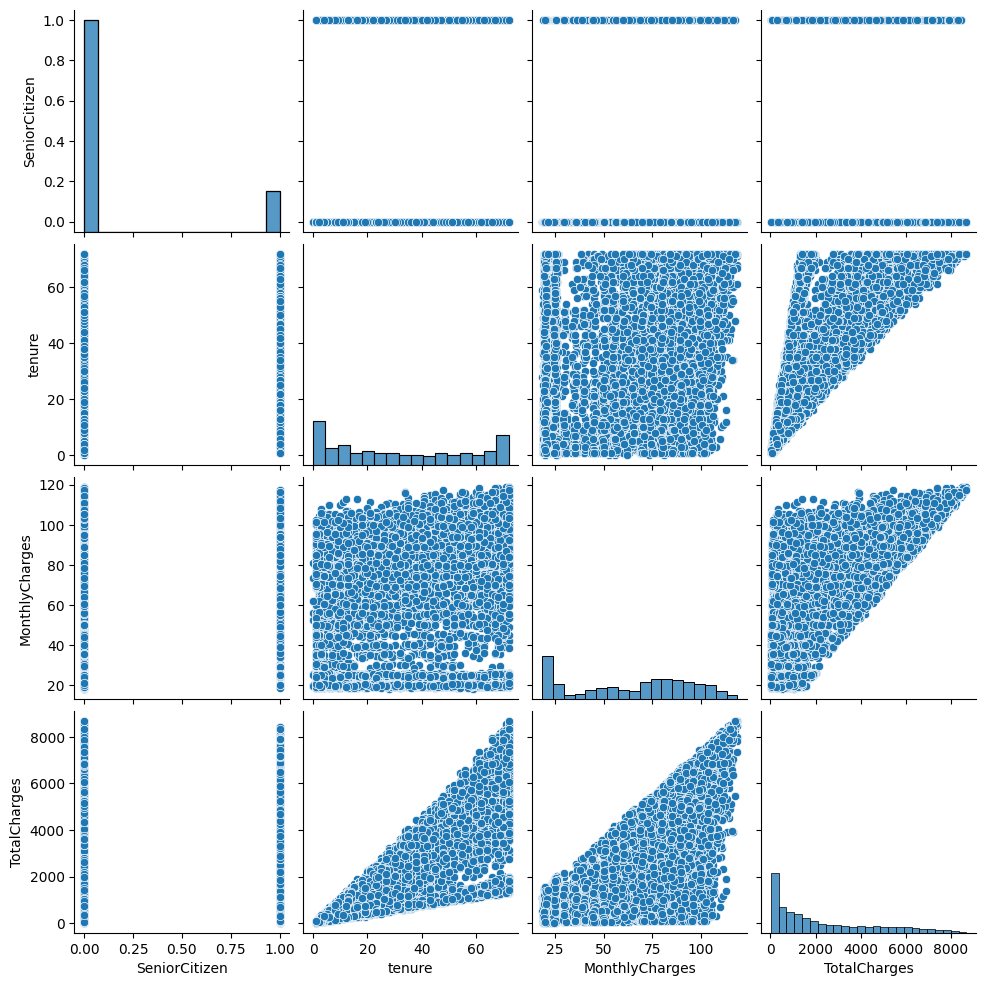

In [ ]:
# PairPlot to visualize relationships between variables
import seaborn as sns
sns.pairplot(df)
plt.show()

In [ ]:
# Display churn distribution
churn_col = 'Churn' if 'Churn' in df.columns else df.columns[-1]
print(f"\nUsing churn column: {churn_col}")
print(df[churn_col].value_counts(dropna=False))


Using churn column: Churn
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [ ]:
# If TotalCharges is present as string, convert it
if 'TotalCharges' in df.columns:
    # coerce errors -> NaN, then fill or impute
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print("\nTotalCharges missing after convert:", df['TotalCharges'].isnull().sum())


TotalCharges missing after convert: 11


In [ ]:
# Basic cleaning
# Drop customerID (identifier)
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Standardize churn column to binary 0/1 if it's 'Yes'/'No'
if df[churn_col].dtype == 'object':
    df[churn_col] = df[churn_col].str.strip().replace({'Yes':1, 'No':0})

# For any boolean-like columns with 'No internet service' or similar, unify to 'No'
replace_no_service = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines']
for col in replace_no_service:
    if col in df.columns:
        df[col] = df[col].replace({'No internet service':'No', 'No phone service':'No'}).astype(object)

In [ ]:
# Feature lists
# Detect categorical and numerical columns automatically
target = churn_col
all_features = [c for c in df.columns if c != target]

num_cols = df[all_features].select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df[all_features].select_dtypes(include=['object','category','bool']).columns.tolist()

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# If 'SeniorCitizen' is integer but categorical semantics, treat as numeric or categorical as desired
if 'SeniorCitizen' in num_cols:
    # keep as numeric but it's okay to treat as numeric; optionally move to categorical
    pass


Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [ ]:
# Train/test split
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (4930, 19), Test shape: (2113, 19)


In [ ]:
# Preprocessing pipelines
# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # drop any other columns
)

In [ ]:
# Model pipelines and hyperparameter grids
# 7.1 Logistic Regression (baseline)
pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1','l2']
}

# 7.2 Random Forest
pipe_rf = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_rf = {
    'clf__n_estimators': [100, 250],
    'clf__max_depth': [None, 8, 16],
    'clf__min_samples_split': [2, 5]
}

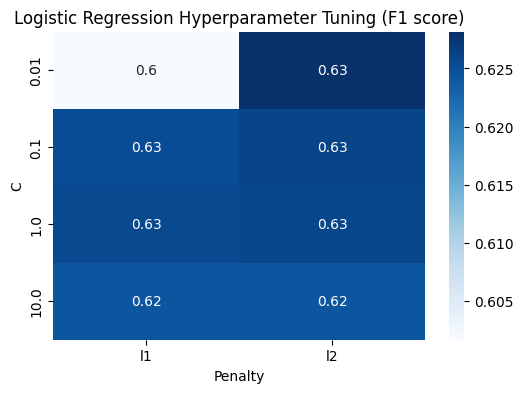

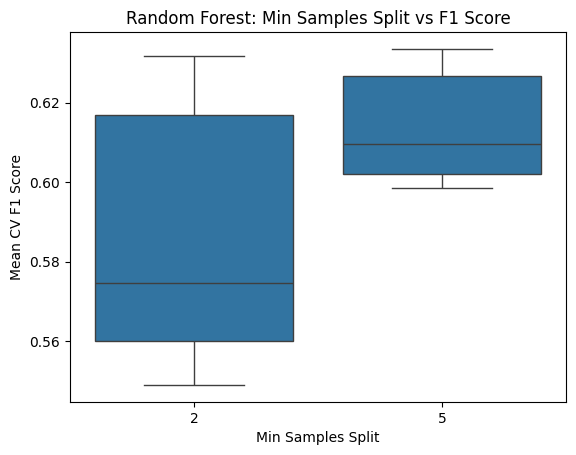

In [ ]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

# Logistic Regression GridSearch
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Random Forest GridSearch
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Logistic Regression results
results_lr = pd.DataFrame(grid_lr.cv_results_)

# Random Forest results
results_rf = pd.DataFrame(grid_rf.cv_results_)

#(a) Logistic Regression – Heatmap of C vs penalty

import seaborn as sns

pivot_lr = results_lr.pivot(index='param_clf__C', columns='param_clf__penalty',
                            values='mean_test_score')

plt.figure(figsize=(6,4))
sns.heatmap(pivot_lr, annot=True, cmap="Blues")
plt.title("Logistic Regression Hyperparameter Tuning (F1 score)")
plt.ylabel("C")
plt.xlabel("Penalty")
plt.show()

# (b) Random Forest – Boxplot for min_samples_split

sns.boxplot(x=results_rf['param_clf__min_samples_split'],
            y=results_rf['mean_test_score'])
plt.title("Random Forest: Min Samples Split vs F1 Score")
plt.xlabel("Min Samples Split")
plt.ylabel("Mean CV F1 Score")
plt.show()

In [ ]:
# Grid search CV
# Fit Logistic Regression
print("\nTuning Logistic Regression...")
grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)
print("Best LR params:", grid_lr.best_params_, "Best AUC:", grid_lr.best_score_)

# Fit Random Forest
print("\nTuning Random Forest...")
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_, "Best AUC:", grid_rf.best_score_)


Tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LR params: {'clf__C': 10, 'clf__penalty': 'l2'} Best AUC: 0.8456020603586614

Tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'clf__max_depth': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 250} Best AUC: 0.8469901806811745


In [ ]:
# Evaluate best models on test set
def evaluate_model(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)[:,1]
    except Exception:
        # maybe decision_function
        try:
            y_proba = model.decision_function(X_test)
        except Exception:
            pass

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n=== {name} Evaluation ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    if auc is not None:
        print("ROC-AUC:", auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return {'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'auc':auc, 'y_proba':y_proba, 'y_pred':y_pred}

# Evaluate LR
best_lr = grid_lr.best_estimator_
res_lr = evaluate_model(best_lr, X_test, y_test, name='Logistic Regression')

# Evaluate RF
best_rf = grid_rf.best_estimator_
res_rf = evaluate_model(best_rf, X_test, y_test, name='Random Forest')


=== Logistic Regression Evaluation ===
Accuracy: 0.7411263606247042
Precision: 0.5079726651480638
Recall: 0.7950089126559715
F1-score: 0.6198749131341209
ROC-AUC: 0.8441531368873697

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1552
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.74      0.75      2113

Confusion Matrix:
 [[1120  432]
 [ 115  446]]

=== Random Forest Evaluation ===
Accuracy: 0.7614765735920492
Precision: 0.5353159851301115
Recall: 0.7700534759358288
F1-score: 0.631578947368421
ROC-AUC: 0.8427926934597644

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      1552
           1       0.54      0.77      0.63       561

    accuracy                           0.76      2113


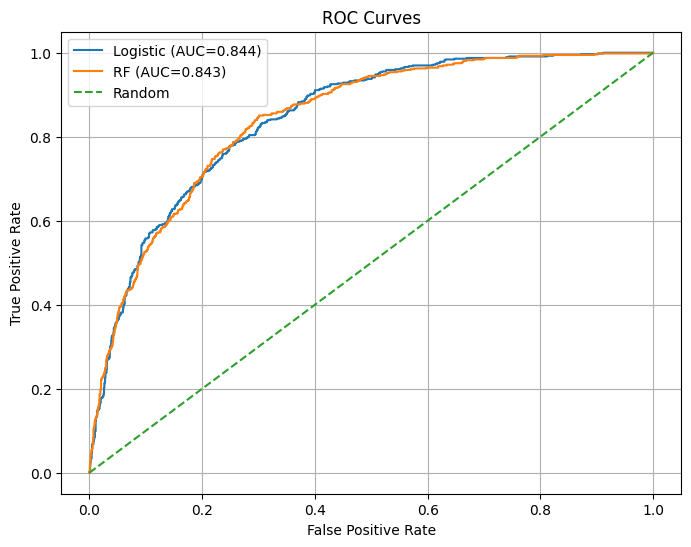

In [ ]:
# Plot ROC curves for the models that provide probabilities
plt.figure(figsize=(8,6))
models_for_roc = []
if res_lr['y_proba'] is not None:
    fpr, tpr, _ = roc_curve(y_test, res_lr['y_proba'])
    plt.plot(fpr, tpr, label=f'Logistic (AUC={res_lr["auc"]:.3f})')
if res_rf['y_proba'] is not None:
    fpr, tpr, _ = roc_curve(y_test, res_rf['y_proba'])
    plt.plot(fpr, tpr, label=f'RF (AUC={res_rf["auc"]:.3f})')

plt.plot([0,1], [0,1], '--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

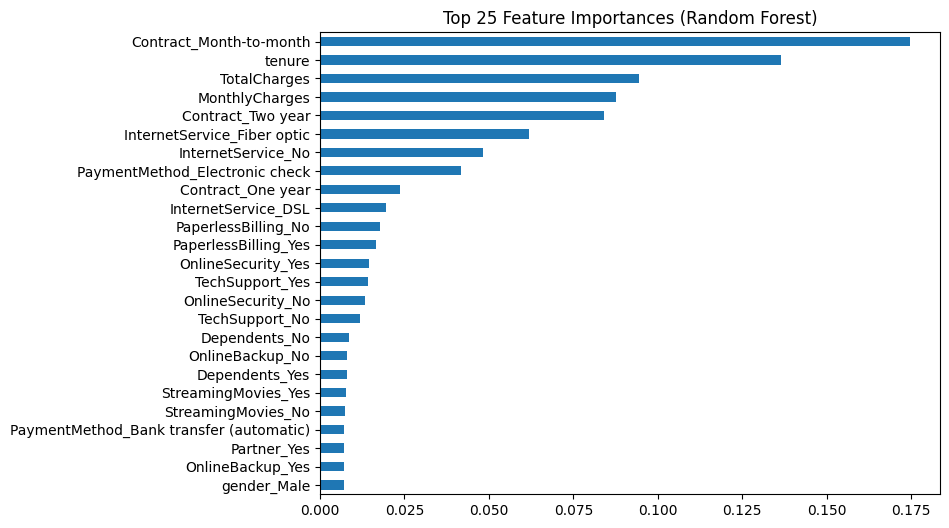

Contract_Month-to-month                    0.174755
tenure                                     0.136510
TotalCharges                               0.094432
MonthlyCharges                             0.087616
Contract_Two year                          0.084148
InternetService_Fiber optic                0.061988
InternetService_No                         0.048369
PaymentMethod_Electronic check             0.041754
Contract_One year                          0.023775
InternetService_DSL                        0.019439
PaperlessBilling_No                        0.017807
PaperlessBilling_Yes                       0.016664
OnlineSecurity_Yes                         0.014513
TechSupport_Yes                            0.014167
OnlineSecurity_No                          0.013404
TechSupport_No                             0.011960
Dependents_No                              0.008704
OnlineBackup_No                            0.007982
Dependents_Yes                             0.007887
StreamingMov

In [ ]:
# Feature importance (Random Forest / XGB)
# To get feature names after preprocessing:
def get_feature_names(preprocessor):
    # numeric names
    num_features = num_cols
    # get ohe feature names
    cat_features = []
    if 'cat' in preprocessor.named_transformers_ and hasattr(preprocessor.named_transformers_['cat'].named_steps['onehot'], 'get_feature_names_out'):
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_features = list(ohe.get_feature_names_out(cat_cols))
    return num_features + cat_features

try:
    feat_names = get_feature_names(best_rf.named_steps['pre'])
    importances = best_rf.named_steps['clf'].feature_importances_
    feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(25)
    plt.figure(figsize=(8,6))
    feat_imp.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title('Top 25 Feature Importances (Random Forest)')
    plt.show()
    print(feat_imp)
except Exception as e:
    print("Could not compute feature importances:", e)

In [ ]:
# 7.3 XGBoost (optional)
if xgb_available:
    pipe_xgb = Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])
    param_grid_xgb = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [3, 6],
        'clf__learning_rate': [0.01, 0.1]
    }

# Fit XGBoost if available
if xgb_available:
    print("\nTuning XGBoost...")
    grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_xgb.fit(X_train, y_train)
    print("Best XGB params:", grid_xgb.best_params_, "Best AUC:", grid_xgb.best_score_)

# Evaluate XGB if available
if xgb_available:
    best_xgb = grid_xgb.best_estimator_
    res_xgb = evaluate_model(best_xgb, X_test, y_test, name='XGBoost')


Tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100} Best AUC: 0.8466329516804111

=== XGBoost Evaluation ===
Accuracy: 0.8021769995267393
Precision: 0.664367816091954
Recall: 0.5151515151515151
F1-score: 0.5803212851405622
ROC-AUC: 0.8447159205762906

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.66      0.52      0.58       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.73      2113
weighted avg       0.79      0.80      0.79      2113

Confusion Matrix:
 [[1406  146]
 [ 272  289]]


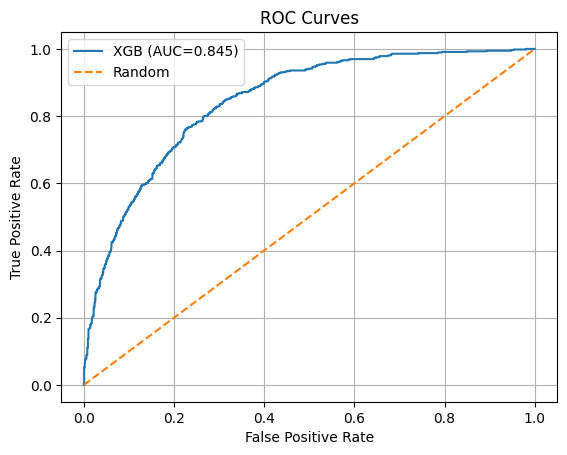

In [ ]:
if xgb_available and res_xgb['y_proba'] is not None:
    fpr, tpr, _ = roc_curve(y_test, res_xgb['y_proba'])
    plt.plot(fpr, tpr, label=f'XGB (AUC={res_xgb["auc"]:.3f})')

plt.plot([0,1], [0,1], '--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Choose final model and save
model_scores = {
    'Logistic': res_lr['auc'] if res_lr['auc'] is not None else 0,
    'RandomForest': res_rf['auc'] if res_rf['auc'] is not None else 0
}
if xgb_available:
    model_scores['XGBoost'] = res_xgb['auc'] if res_xgb['auc'] is not None else 0

best_model_name = max(model_scores, key=model_scores.get)
print("\nModel test AUCs:", model_scores)
print("Best model by AUC:", best_model_name)

if best_model_name == 'RandomForest':
    final_model = best_rf
elif best_model_name == 'Logistic':
    final_model = best_lr
else:
    final_model = best_xgb

# Save final model and feature lists
joblib.dump(final_model, 'final_churn_model.pkl')
print("Saved model to final_churn_model.pkl")

# Save columns used for reference in production (useful for later)
meta = {
    'num_cols': num_cols,
    'cat_cols': cat_cols,
    'target': target
}
joblib.dump(meta, 'model_metadata.pkl')
print("Saved metadata to model_metadata.pkl")


Model test AUCs: {'Logistic': np.float64(0.8441531368873697), 'RandomForest': np.float64(0.8427926934597644), 'XGBoost': np.float64(0.8447159205762906)}
Best model by AUC: XGBoost
Saved model to final_churn_model.pkl
Saved metadata to model_metadata.pkl
